<a href="https://colab.research.google.com/github/koyomin9zx/CS313.K21-Homework/blob/master/Youtube_Spam_Detection-v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Preprocessing***

**download & extract dataset**

In [0]:
!wget -O data.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00380/YouTube-Spam-Collection-v1.zip
!unzip data.zip

In [0]:
!pip install scikit-learn==0.23.1

**import lib**

In [0]:
import pandas as pd
import glob
import seaborn as sns
import string
from string import digits, punctuation
import re
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.backend import clear_session
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
import joblib
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')


**Import data into Pandas**

In [4]:
def load_data(path):
  all_files = glob.glob(path + "/*.csv")

  li = []

  for filename in all_files:
      data_frame = pd.read_csv(filename, index_col=None, header=0, encoding='utf-8')
      li.append(data_frame)

  df = pd.concat(li, axis=0, ignore_index=True)
  return df

df=load_data('/content')
df.head(5)


,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,z13lgffb5w3ddx1ul22qy1wxspy5cpkz504,dharma pal,2015-05-29T02:30:18.971000,Nice song﻿,0
1,z123dbgb0mqjfxbtz22ucjc5jvzcv3ykj,Tiza Arellano,2015-05-29T00:14:48.748000,I love song ﻿,0
2,z12quxxp2vutflkxv04cihggzt2azl34pms0k,Prìñçeśś Âliś Łøvê Dømíñø Mâđiś™ ﻿,2015-05-28T21:00:08.607000,I love song ﻿,0
3,z12icv3ysqvlwth2c23eddlykyqut5z1h,Eric Gonzalez,2015-05-28T20:47:12.193000,"860,000,000 lets make it first female to reach...",0
4,z133stly3kete3tly22petvwdpmghrlli,Analena López,2015-05-28T17:08:29.827000,shakira is best for worldcup﻿,0


**DATA VISUALIZATION**

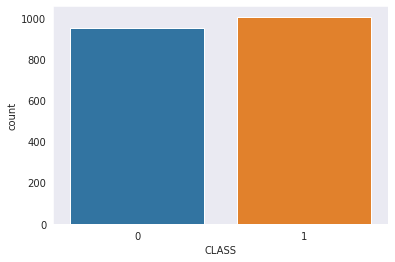

In [5]:
sns.set_style("dark")
sns.countplot(df.CLASS)

**See how our content look like**

In [6]:
  for i,content in enumerate (df['CONTENT'], 1):
    if i > 40:
        break
    else:
        print(i, content)



1 Nice song﻿
2 I love song ﻿
3 I love song ﻿
4 860,000,000 lets make it first female to reach one billion!! Share it and replay it! ﻿
5 shakira is best for worldcup﻿
6 The best world cup song ever!!!!﻿
7 I love﻿
8 SEE SOME MORE SONG OPEN GOOGLE AND TYPE Shakira GuruOfMovie﻿
9 Awesome ﻿
10 I like shakira..﻿
11 Shakira - Waka Waka <br />LOVE THIS SONG!!!!!!!!!!!!!!!﻿
12 Why so many disliked??????!!!!!!😯﻿
13 I don&#39;t think this song will ever get old ﻿
14 Love song﻿
15 wery good﻿
16 Every time I hear this song, I think about Iniesta&#39;s goal against the Netherlands...﻿
17 Whose watching this in 2015. If so hi-5﻿
18 I love this song so much &lt;3<br />Keep em&#39; coming!﻿
19 i love this song thumsb up to you﻿
20 Waka best one﻿
21 5 years later i still love this song <br />~Axy665﻿
22 Like﻿
23 Check out this playlist on YouTube:﻿
24 Her voice sounds weird and plus she&#39;s cute for a blonde﻿
25 Why there are so many dislikes. This song is so... awesome. It sounds like we MUST STOP BE

In [9]:
text="Hello everyone, my name is CHICKEN, my infomation https://www.youtube.com/watch?v=T0sHaz4H9MQ, kukir@gmail.com, 888.456.1478, 800 $ "
text=standardize_data(text)
print(remove_stopwords(text))


['hello', 'everyone', 'name', 'chicken', 'infomation', 'webaddress', 'email', 'phonenb', 'numbr', 'moneysb']


**Standardize data, remove punctuation, remove stopwords, tokenization**

In [8]:
def standardize_data(text):
  text=text.lower()
  # Replace email addresses with 'email'
  re_email=re.compile('[\w\.-]+@[\w\.-]+(\.[\w]+)+')
  text=re.sub(re_email,'email',text)

  # Replace URLs with 'webaddress'
  re_url=re.compile('(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')
  text=re.sub(re_url,'webaddress',text)

  # Replace money symbols with 'moneysymb'
  re_moneysb=re.compile('\$')
  text=re.sub(re_moneysb,'moneysb',text)

  # Remove ufeff 
  re_moneysb=re.compile('\ufeff|\\ufeff')
  text=re.sub(re_moneysb,' ',text)

  # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
  re_phonenb=re.compile('(\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4})')
  text=re.sub(re_phonenb,'phonenb',text)

  # Replace numbers with 'numbr'
  re_number=re.compile('\d+(\.\d+)?')
  text=re.sub(re_number,'numbr',text)

  # Remove puntuation
  text=text.translate(str.maketrans('', '', punctuation))

  # Replace whitespace between terms with a single space
  re_space=re.compile('\s+')
  text=re.sub(re_space,' ',text)

  # Remove leading and trailing whitespace
  re_space=re.compile('^\s+|\s+?$')
  text=re.sub(re_space,' ',text)

  return text


def remove_stopwords(text):
  stop_words = set(stopwords.words('english'))
  token=[term for term in text.split() if term not in stop_words]
  return token

hl_tokens = []

for hl in df['CONTENT']:
    hl=standardize_data(hl)
    hl=remove_stopwords(hl)
    hl_tokens.append(hl)
    
# View comparison
index=7
print('Original texts :')
print(df['CONTENT'][index])
print('\nAfter cleansed :')
print(hl_tokens[index])

Original texts :
SEE SOME MORE SONG OPEN GOOGLE AND TYPE Shakira GuruOfMovie﻿

After cleansed :
['see', 'song', 'open', 'google', 'type', 'shakira', 'guruofmovie']


**Lemmatization**

In [0]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Init Lemmatizer
lemmatizer = WordNetLemmatizer()

hl_lemmatized = []
for tokens in hl_tokens:
    lemm = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]
    hl_lemmatized.append(lemm)
    

In [11]:
# Example comparison
index=7
word_1 = hl_tokens[index]
word_2 = hl_lemmatized[index]
print('Before lemmatization\n',word_1)
print('\nAfter lemmatization\n',word_2)

Before lemmatization
 ['see', 'song', 'open', 'google', 'type', 'shakira', 'guruofmovie']

After lemmatization
 ['see', 'song', 'open', 'google', 'type', 'shakira', 'guruofmovie']


Number of words: 3598
Most common words: [('check', 565), ('numbr', 389), ('video', 374), ('song', 323), ('like', 264), ('please', 242), ('subscribe', 228), ('love', 212), ('youtube', 208), ('channel', 194), ('get', 168), ('webaddress', 164), ('make', 162), ('music', 149), ('guy', 136)]


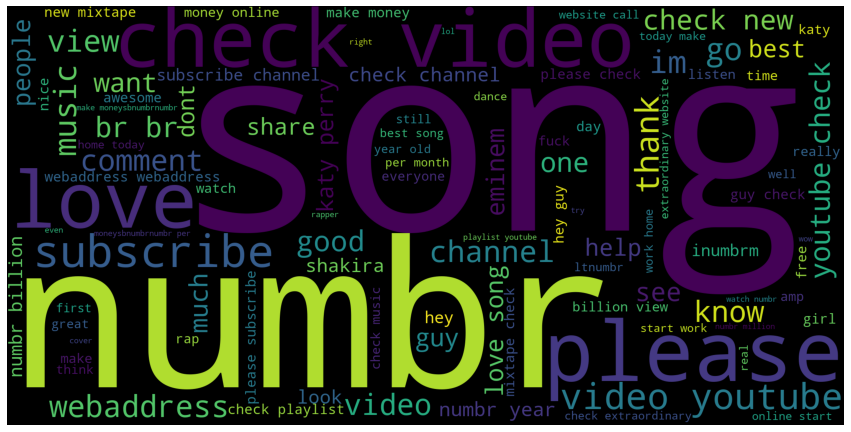

In [12]:
# create bag-of-words
all_words = []

for token in hl_lemmatized:
    for w in token:
          all_words.append(w)

corpus=' '.join(all_words)
all_words = nltk.FreqDist(all_words)

# print the total number of words and the 15 most common words
print('Number of words: {}'.format(len(all_words)))
print('Most common words: {}'.format(all_words.most_common(15)))


import wordcloud
import matplotlib.pyplot as plt
%matplotlib inline
#cloud = np.array(all_words).flatten()
plt.figure(figsize=(15,10))
word_cloud = wordcloud.WordCloud(max_words=100,background_color ="black",
                               width=2000,height=1000,mode="RGB").generate(corpus)
plt.axis("off")
plt.imshow(word_cloud)

# ***Training LSTM Model***

In [0]:
# Vectorize and convert text into sequences
def vectorize_lstm(text):
  text=word_lenmatizer(text)
  sequences = tokenizer.texts_to_sequences(text)
  X = pad_sequences(sequences, maxlen=14)
  return X

max_features = 2000
max_token = len(max(hl_lemmatized,key=len))
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(hl_lemmatized)
sequences = tokenizer.texts_to_sequences(hl_lemmatized)
X = pad_sequences(sequences, maxlen=max_token)

In [14]:
print('Before vectorization & padding\n',hl_lemmatized[0])
print('\nAfter vectorization & padding\n',X[0])


Before vectorization & padding
 ['nice', 'song']

After vectorization & padding
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0 72  4]


Split Train, Test

In [0]:
Y = df['CLASS'].values
Y = np.vstack(Y)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3, random_state = 42)

In [0]:
clear_session()

Building the Model

In [16]:
embed_dim = 64
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = max_token))
model.add(LSTM(96, dropout=0.2, recurrent_dropout=0.2, activation='relu'))
model.add(Dense(100))
model.add(BatchNormalization())
# model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 103, 64)           128000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 96)                61824     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               9700      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                

Training process

In [17]:
epoch = 40
batch_size = 128
history=model.fit(X_train, Y_train, epochs = epoch, batch_size=batch_size, verbose = 2, validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1095 samples, validate on 274 samples
Epoch 1/40
 - 4s - loss: 0.6362 - accuracy: 0.6082 - val_loss: 0.6847 - val_accuracy: 0.7299
Epoch 2/40
 - 2s - loss: 0.4670 - accuracy: 0.7954 - val_loss: 0.6711 - val_accuracy: 0.8650
Epoch 3/40
 - 2s - loss: 0.2775 - accuracy: 0.9014 - val_loss: 0.6399 - val_accuracy: 0.8577
Epoch 4/40
 - 2s - loss: 0.1520 - accuracy: 0.9443 - val_loss: 0.6094 - val_accuracy: 0.8212
Epoch 5/40
 - 2s - loss: 0.0998 - accuracy: 0.9699 - val_loss: 0.5875 - val_accuracy: 0.8321
Epoch 6/40
 - 2s - loss: 0.0872 - accuracy: 0.9744 - val_loss: 0.5762 - val_accuracy: 0.8066
Epoch 7/40
 - 2s - loss: 0.0643 - accuracy: 0.9781 - val_loss: 0.5611 - val_accuracy: 0.7628
Epoch 8/40
 - 2s - loss: 0.0521 - accuracy: 0.9854 - val_loss: 0.5540 - val_accuracy: 0.7591
Epoch 9/40
 - 2s - loss: 0.0531 - accuracy: 0.9808 - val_loss: 0.5408 - val_accuracy: 0.7445
Epoch 10/40
 - 2s - loss: 0.0500 - accuracy: 0.9826 - val_loss: 0.5346 - val_accuracy: 0.7555
Epoch 11/40
 - 2s - lo

# ***Model Evaluation***



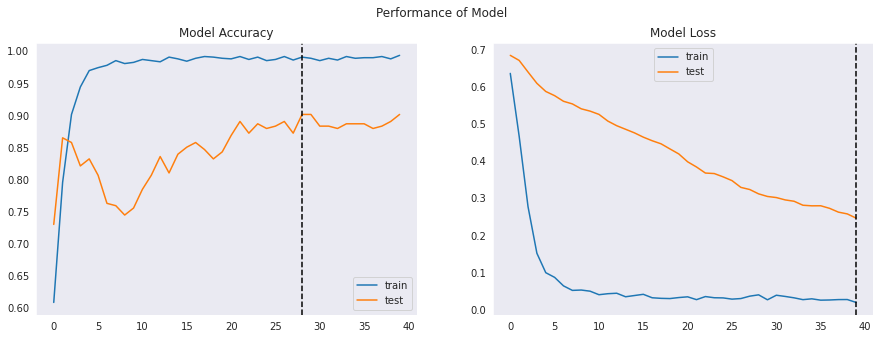

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance of Model")
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
vline_cut = np.where(history.history['val_accuracy'] == np.max(history.history['val_accuracy']))[0][0]
ax1.axvline(x=vline_cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'test'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=vline_cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'test'])
plt.show()

# ***Test Model***

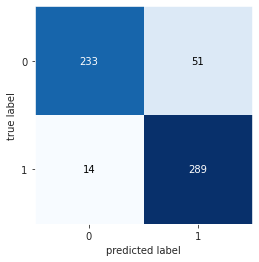

In [19]:
pred=np.around(model.predict(X_test))
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(Y_test,pred))
plt.show()

In [0]:
print(classification_report(Y_test,pred))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90       317
           1       0.85      0.96      0.90       270

    accuracy                           0.90       587
   macro avg       0.90      0.91      0.90       587
weighted avg       0.91      0.90      0.90       587



# ***Use Another ML Algorithms to Classify***

**Preparing the Data**

In [0]:
X = [" ".join(x) for x in hl_lemmatized]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X,df['CLASS'],test_size=0.3)

**Word Vectorization using TF-IDF**

In [0]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(X)
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [22]:
print(Tfidf_vect.vocabulary_)

{'nice': 1990, 'song': 2732, 'love': 1735, 'numbrnumbrnumbr': 2067, 'let': 1655, 'make': 1780, 'first': 1039, 'female': 1014, 'reach': 2418, 'one': 2116, 'billion': 289, 'share': 2627, 'replay': 2475, 'shakira': 2619, 'best': 271, 'worldcup': 3350, 'world': 3349, 'cup': 637, 'ever': 912, 'see': 2588, 'open': 2124, 'google': 1186, 'type': 3085, 'guruofmovie': 1235, 'awesome': 203, 'like': 1667, 'waka': 3204, 'br': 345, 'many': 1790, 'disliked': 746, 'donnumbrt': 774, 'think': 2982, 'get': 1151, 'old': 2106, 'wery': 3290, 'good': 1181, 'every': 916, 'time': 3004, 'hear': 1286, 'iniestanumbrs': 1450, 'goal': 1172, 'netherlands': 1982, 'whose': 3310, 'watch': 3226, 'numbr': 2033, 'hinumbr': 1314, 'much': 1934, 'ltnumbrbr': 1746, 'keep': 1581, 'emnumbr': 864, 'come': 526, 'thumsb': 2996, 'year': 3396, 'later': 1632, 'still': 2816, 'axynumbr': 213, 'check': 453, 'playlist': 2244, 'youtube': 3423, 'voice': 3189, 'sound': 2757, 'weird': 3282, 'plus': 2262, 'shenumbrs': 2631, 'cute': 645, 'blon

## **Trainning on the SVM classifier**

In [23]:
SVM = svm.SVC(C=1.0, kernel='linear', verbose=True)
SVM.fit(Train_X_Tfidf,Train_Y)

[LibSVM]

SVC(kernel='linear', verbose=True)

**Predict and evaluate the SVM classifier**

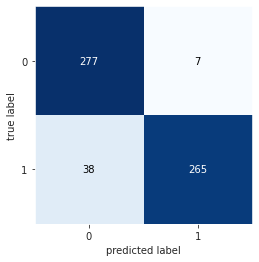

In [24]:
predictions_SVM=SVM.predict(Test_X_Tfidf)
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(Test_Y,predictions_SVM))
plt.show()

In [25]:
print(classification_report(Test_Y,predictions_SVM))

              precision    recall  f1-score   support

           0       0.88      0.98      0.92       284
           1       0.97      0.87      0.92       303

    accuracy                           0.92       587
   macro avg       0.93      0.92      0.92       587
weighted avg       0.93      0.92      0.92       587



## **Trainning on the Naive Bayes Classifier**

In [27]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)

MultinomialNB()

**Predict and evaluate the Naive Bayes Classifier**

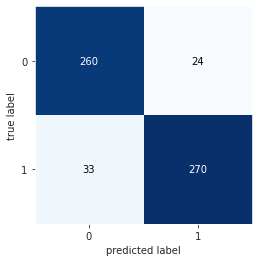

In [28]:
predictions_NB=Naive.predict(Test_X_Tfidf)
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(Test_Y,predictions_NB))
plt.show()

In [29]:
print(classification_report(Test_Y,predictions_NB))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       284
           1       0.92      0.89      0.90       303

    accuracy                           0.90       587
   macro avg       0.90      0.90      0.90       587
weighted avg       0.90      0.90      0.90       587



# ***Save model***

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [31]:
joblib.dump(Tfidf_vect, '/content/drive/My Drive/model/tfidf.pkl')
joblib.dump(tokenizer, '/content/drive/My Drive/model/tokenizer_LSTM.pkl')
joblib.dump(model, '/content/drive/My Drive/model/LSTM_model.pkl')
joblib.dump(SVM, '/content/drive/My Drive/model/SVM_model.pkl')
joblib.dump(Naive, '/content/drive/My Drive/model/NB_model.pkl')
joblib.dump(Tfidf_vect.vocabulary_,'/content/drive/My Drive/model/vocalbulary.pkl' )

['/content/drive/My Drive/model/vocalbulary.pkl']

# ***Enter comment and check***

## *utils*

In [0]:
!ln -s /content/drive/'My Drive'/model

In [0]:
from nltk.corpus import wordnet,stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report,confusion_matrix
import re
import string
from string import digits, punctuation
import pandas as pd
import joblib

def load_data(path):
  all_files = glob.glob(path + "/*.csv")
  li = []
  for filename in all_files:
      data_frame = pd.read_csv(filename, index_col=None, header=0, encoding='utf-8')
      li.append(data_frame)

  df = pd.concat(li, axis=0, ignore_index=True)
  return df


def standardize_data(text):
  # Replace email addresses with 'email'
  re_email=re.compile('[\w\.-]+@[\w\.-]+(\.[\w]+)+')
  text=re.sub(re_email,'email',text)

  # Replace URLs with 'webaddress'
  re_url=re.compile('(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')
  text=re.sub(re_url,'webaddress',text)

  # Replace money symbols with 'moneysymb'
  re_moneysb=re.compile('\$')
  text=re.sub(re_moneysb,'moneysb',text)

  # Remove ufeff 
  re_moneysb=re.compile('\ufeff|\\ufeff')
  text=re.sub(re_moneysb,' ',text)

  # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
  re_phonenb=re.compile('(\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4})')
  text=re.sub(re_phonenb,'phonenb',text)

  # Replace numbers with 'numbr'
  re_number=re.compile('\d+(\.\d+)?')
  text=re.sub(re_number,' numbr ',text)

  # Remove puntuation
  text=text.translate(str.maketrans('', '', punctuation))

  # Replace whitespace between terms with a single space
  re_space=re.compile('\s+')
  text=re.sub(re_space,' ',text)

  # Remove leading and trailing whitespace
  re_space=re.compile('^\s+|\s+?$')
  text=re.sub(re_space,' ',text)

  return text


def remove_stopwords(text):
  stop_words = set(stopwords.words('english'))
  token=[term for term in text.split() if term not in stop_words]
  return token

def word_lenmatizer(token):
    # Init Lemmatizer
    lemmatizer = WordNetLemmatizer()
    hl_lemmatized = []
    lemm = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in token]
    hl_lemmatized.append(lemm)
    return hl_lemmatized

def vectorize_lstm(w_lenmatizer,tokenizer):
  sequences = tokenizer.texts_to_sequences(w_lenmatizer)
  X = pad_sequences(sequences, maxlen=110)
  return X


def vectorize_clasifer(w_lenmatizer, tfidf_vector):
  w_lenmatizer = [" ".join(x) for x in w_lenmatizer]
  return tfidf_vector.transform(w_lenmatizer)


def LSTM_predict(text,model,tokenizer):
  print(text)
  text=standardize_data(text)
  token=remove_stopwords(text)
  w_lenmatizer=word_lenmatizer(token)
  max_token = 110
  sequences = tokenizer.texts_to_sequences(w_lenmatizer)
  X = pad_sequences(sequences, maxlen=max_token)
  if np.around(model.predict(X)[0])==1:
    print("=============> SPAM\n")
  else:
    print("=============> HAM\n")

def predict(text,model,tfidf_vector):
  print(text)
  text=standardize_data(text)
  token=remove_stopwords(text)
  w_lenmatizer=word_lenmatizer(token)
  w_lenmatizer = [" ".join(x) for x in w_lenmatizer]
  X_Tfidf = tfidf_vector.transform(w_lenmatizer)
  if model.predict(X_Tfidf)[0]==1:
    print("=============> SPAM\n")
  else:
    print("=============> HAM\n")

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def multi_predict(path,model,tokenizer,choice):
  df=load_data(path)
  hl_tokens = []
  for hl in df['CONTENT']:
      hl=standardize_data(hl)
      hl=remove_stopwords(hl)
      hl_tokens.append(hl)
  # Init Lemmatizer
  lemmatizer = WordNetLemmatizer()
  hl_lemmatized = []
  for tokens in hl_tokens:
      lemm = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]
      hl_lemmatized.append(lemm)

  if choice==0:
      sequences = tokenizer.texts_to_sequences(hl_lemmatized)
      X = pad_sequences(sequences, maxlen=110)
      Y = df['CLASS'].values
      Y = np.vstack(Y)
      pred=np.around(model.predict(X))
      return classification_report(Y,pred)
  else:
      X = [" ".join(x) for x in hl_lemmatized]
      Test_X_Tfidf = tokenizer.transform(X)
      Y = df['CLASS'].values
      pred=model.predict(Test_X_Tfidf)
      return classification_report(Y,pred)


model_LSTM=joblib.load('/content/model/LSTM_model.pkl')
tokenizer_LSTM=joblib.load('/content/model/tokenizer_LSTM.pkl')
SVM_model=joblib.load('/content/model/SVM_model.pkl')
NB_model=joblib.load('/content/model/NB_model.pkl')
tfidf_vec=joblib.load('/content/model/tfidf.pkl')

## Explaining function

* **Step 1**: Standardize text, remove punctuation, replace url = 'webaddrress', replace email= 'email', replace phone_number = 'phonenb', replace money_sign = 'moneysb'*

In [43]:
text="I like this song very much"

clean=standardize_data(text)
print('Raw: ', text)
print('\nResult: ',clean)

Raw:  I like this song very much

Result:  I like this song very much


* **Step 2**: Remove stopwords and tokenization *

In [44]:
token=text=remove_stopwords(clean)

print('text: ', clean)
print('\nResult: ',token)

text:  I like this song very much

Result:  ['I', 'like', 'song', 'much']


* **Step 3**: Lemmatizer *


In [45]:
w_lenmatizer=word_lenmatizer(token)

print('token: ', token)
print('\nResult: ',w_lenmatizer)

token:  ['I', 'like', 'song', 'much']

Result:  [['I', 'like', 'song', 'much']]


* **Step 4**: Vectorization & padding *



In [46]:
print('Input for LSTM model: ', vectorize_lstm(w_lenmatizer,tokenizer_LSTM))

Input for LSTM model:  [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  5  4 41]]


In [38]:
print('Input vectorization by TF-IDF:\n', vectorize_clasifer(w_lenmatizer,tfidf_vec))

Input vectorization by TF-IDF:
   (0, 3253)	0.19938031345342244
  (0, 3181)	0.2526220478644767
  (0, 2581)	0.3388083663512019
  (0, 2249)	0.4322491421766113
  (0, 2213)	0.39425630874415246
  (0, 2033)	0.1588999434195054
  (0, 1419)	0.23507300216739868
  (0, 1305)	0.22608996919079244
  (0, 1237)	0.2087508646595952
  (0, 855)	0.39425630874415246
  (0, 788)	0.27232008161456744
  (0, 437)	0.18591060934426182


## Predict

Using LSTM model to predict

In [0]:
cmt='Please subcribe my channel https://www.youtube.com/watch?v=UZ0Dv9sGYvU&list=RDUZ0Dv9sGYvU&start_radio=1'
LSTM_predict(cmt,model_LSTM,tokenizer_LSTM)


cmt2='I just remembered the song because of Alvin and The Chipmunks 😂'
LSTM_predict(cmt2,model_LSTM,tokenizer_LSTM)

Please subcribe my channel https://www.youtube.com/watch?v=UZ0Dv9sGYvU&list=RDUZ0Dv9sGYvU&start_radio=1
=============> SPAM

I just remembered the song because of Alvin and The Chipmunks 😂
=============> HAM



Using SVM clasifier

In [0]:
cmt='Follow me on instagram, remember to like and subcribe'
predict(cmt,SVM_model,tfidf_vec)


cmt2='This is probably the best song that represents the world cup ever.'
predict(cmt2,SVM_model,tfidf_vec)

Follow me on instagram, remember to like and subcribe
=============> SPAM

This is probably the best song that represents the world cup ever.
=============> HAM



Using NB clasifier


In [0]:
cmt='Such a shame that this song didnt reach 1B in 10 years.'
predict(cmt,NB_model,tfidf_vec)


cmt2='LIKE THIS COMMENT IF YOU ARE WATCHING.'
predict(cmt2,NB_model,tfidf_vec)

Such a shame that this song didnt reach 1B in 10 years.
=============> HAM

LIKE THIS COMMENT IF YOU ARE WATCHING.
=============> SPAM



Multi predict with LSTM model

In [0]:
a=multi_predict('/content',model_LSTM,tokenizer_LSTM,0)
print(a)


              precision    recall  f1-score   support

           0       0.96      0.93      0.94       951
           1       0.94      0.96      0.95      1005

    accuracy                           0.95      1956
   macro avg       0.95      0.94      0.95      1956
weighted avg       0.95      0.95      0.95      1956
LOLLL


Multi predict with SVM clasifer

In [0]:
a=multi_predict('/content',SVM_model,tfidf_vec,1)
print(a)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       951
           1       0.99      0.94      0.96      1005

    accuracy                           0.96      1956
   macro avg       0.96      0.96      0.96      1956
weighted avg       0.96      0.96      0.96      1956



Multi predict with NB clasifer

In [0]:
a=multi_predict('/content',NB_model,tfidf_vec,1)
print(a)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       951
           1       0.94      0.94      0.94      1005

    accuracy                           0.94      1956
   macro avg       0.94      0.94      0.94      1956
weighted avg       0.94      0.94      0.94      1956

